In [119]:
ls

Untitled.ipynb
__pycache__/
centroids_information.pkl
clusters_exploration_COMA_intero.ipynb
clusters_exploration_COMA_new_ground_truth.ipynb
clusters_exploration_new_dataset.ipynb
clusters_renderings/
data/
data_old/
explore_train_space.ipynb
final_clusters_exploration_COMA_TOP-new_GT.ipynb
final_clusters_exploration_COMA_TOP.ipynb
final_clusters_exploration_COMA_intero.ipynb
final_clusters_exploration_COMA_intero_new_GT.ipynb
fix_test_train.ipynb
new_ground_truth_clusters.ipynb
out_prova.png
outliars_renderings/
reference_meshes/
render_clusters.py
render_outliers.py
render_videos.py
rendering_utils.py
sample_convex_hull.ipynb
videos/


In [120]:
import pandas as pd
import numpy as np
import hdbscan
import umap

In [121]:
#!pip install hdbscan
#!pip install umap-learn
van_gt = "vanilla"

In [122]:
test_df = pd.read_csv(f"./data/new_dataset/vanilla/test_nasi_metadata.csv")
train_df = pd.read_csv(f"./data/new_dataset/vanilla/train_nasi_metadata.csv")

In [123]:
test_latents = np.load(f"./data/new_dataset/{van_gt}/latents_test.npy")
train_latents = np.load(f"./data/new_dataset/{van_gt}/latents_train.npy")

In [124]:
print(f"Test latents shape: {test_latents.shape}, train latents shape: {train_latents.shape}")

Test latents shape: (1849, 16), train latents shape: (4952, 16)


In [125]:
print(f"Test dataframe shape: {test_df.shape}, train dataframe shape: {train_df.shape}")
assert test_df.shape[0] == test_latents.shape[0]
assert train_df.shape[0] == train_latents.shape[0]

Test dataframe shape: (1849, 4), train dataframe shape: (4952, 4)


In [126]:
test_df.iloc[[5]]

,Unnamed: 0,mesh_file_name,expr_info,gender
5,5,04796d144.ply,L,W


In [127]:
#train_df.iloc[[5]]
all_df = pd.concat([train_df, test_df])

In [128]:
all_df.shape

(6801, 4)

In [129]:
#all_df.tail(10)

In [130]:
all_latents = np.vstack((train_latents, test_latents))

In [131]:
assert (all_latents[1] == train_latents[1]).all()

I do clustering here, instead of loading preprocessed data

Silhouette method for number of clusters

In [132]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tqdm import tqdm

In [69]:
calculate_num_clusters = False
if calculate_num_clusters:
    sil = []
    kmax = 150

    Sum_of_squared_distances = [] #for elbow method
    ks = range(2, kmax+1)
    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in tqdm(ks):
      kmeans = KMeans(n_clusters = k).fit(all_latents)
      labels = kmeans.labels_
      sil.append(silhouette_score(all_latents, labels, metric = 'euclidean'))
      Sum_of_squared_distances.append(kmeans.inertia_) #for elbow method

In [70]:
max(labels)
plt.plot(range(2, kmax+1),sil, scalex=True, scaley=True, data=None)
plt.title("Silouhette score")


NameError: name 'labels' is not defined

In [143]:
cluster = KMeans(n_clusters = 16).fit(all_latents)


In [80]:

plt.plot(ks, Sum_of_squared_distances)
#plt.plot(range(2, kmax+1),Sum_of_squared_distances, scalex=True, scaley=True, data=None)

plt.xlabel("Values of K") 
plt.ylabel("Sum of squared distances/Inertia") 
plt.title("Elbow Method For Optimal k")
plt.show()

NameError: name 'ks' is not defined

In [141]:
cluster = hdbscan.HDBSCAN(min_cluster_size=2,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(all_latents)
#for now it was trial and error, however the correct "minclustersize" can be calculated using some trials

In [142]:
max(cluster.labels_)

549

In [146]:
import matplotlib.pyplot as plt
import umap.umap_ as umap
def plotClusters(funClusters, latents):
    umap_data = umap.UMAP(n_neighbors=100, n_components=2, min_dist=0.0, metric='cosine').fit_transform(latents)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = funClusters.labels_
    plt.figure(figsize = (16,16))

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(10, 7))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
    plt.colorbar()
    plt.title("Visualization of one instance of clustering through HDBSCAN")

<Figure size 1152x1152 with 0 Axes>

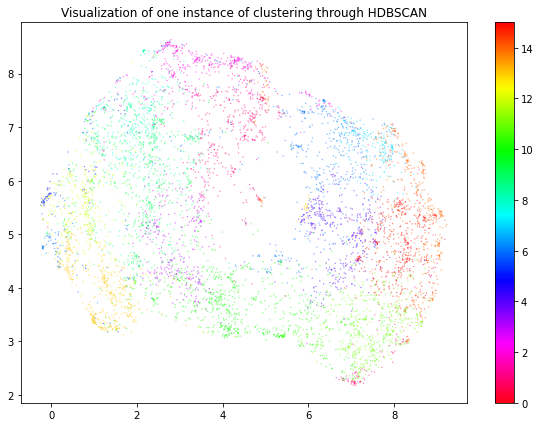

In [147]:
plotClusters(cluster, all_latents)

In [104]:
one_count = 0
two_count = 0
for label in cluster.labels_:
    if label == 0:
        one_count += 1
    else:
        two_count +=1

In [106]:
'''
for each label, check if corresponding csv thingy is male or female
'''

all_df.iloc[[1]]['gender']

1    M
Name: gender, dtype: object

0       M
1       M
2       M
3       M
4       M
       ..
1844    F
1845    F
1846    F
1847    F
1848    F
Name: gender, Length: 6801, dtype: object

In [107]:
clusters_lists = [set() for i in range(0, max(cluster.labels_)+1)]
#I want to make sets of clusters labels, individuals ids and more if necessary (e.g. expressions?)
for i in range(len(cluster.labels_)):
    if cluster.labels_[i] != -1:
        clusters_lists[cluster.labels_[i]].add(i)


In [114]:
import copy
clusters_information = []
for cluster in clusters_lists:
    one_cluster_inf = {'M': 0, 'F':0}
    for item in cluster: 
        if all_df.iloc[[item]]['gender'].values[0] == 'M':
            one_cluster_inf['M']+=1
        else:
            one_cluster_inf['F']+=1
    clusters_information.append(copy.copy(one_cluster_inf))

In [116]:
clusters_information[1]

{'M': 1838, 'F': 1134}

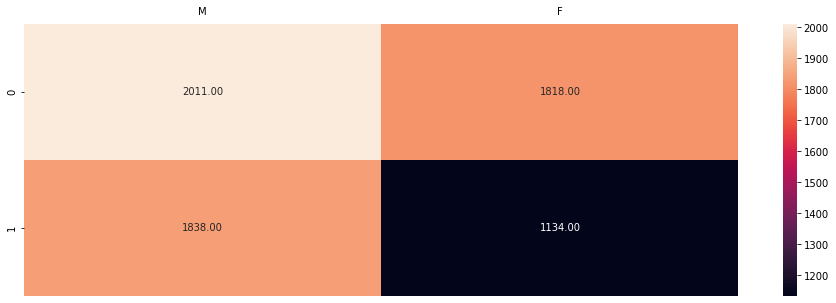

In [118]:
import seaborn as sns

df = pd.DataFrame.from_dict(clusters_information)
plt.figure(figsize = (16,5))

plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax = sns.heatmap(df, annot=True, fmt='.2f')


In [157]:
train_latents.shape

(4952, 16)

In [158]:
test_latents.shape

(1849, 16)

In [163]:
train_labels = list()
for i in range(len(train_df)):
    if train_df.iloc[[i]]['gender'].values[0] == 'M':
        train_labels.append(1)
    else: 
        train_labels.append(-1)

train_labels_np = np.array(train_labels)

print(f"Test labels len {len(train_labels)}")
print(f"Test np {train_labels_np.shape}")

Test labels len 4952
Test np (4952,)


In [161]:
test_labels = list()
for i in range(len(test_df)):
    if test_df.iloc[[i]]['gender'].values[0] == 'M':
        test_labels.append(1)
    else: 
        test_labels.append(-1)

test_labels_np = np.array(test_labels)
print(f"Test labels len {len(test_labels)}")
print(f"Test np {test_labels_np.shape}")

Test labels len 1849
Test np (1849,)


In [182]:
for latent in train_latents:
    print(latent)

[-1.1077787   1.4833232   1.8365015   0.3145638  -2.304434   -3.0282772
 -1.3927482   0.3662238  -1.2102224  -0.6824363  -2.1952522  -1.0555372
  2.6018486  -1.4681839   0.17572483  0.4423136 ]
[-1.4657804   0.581332    1.3846835   0.39675876 -1.905194   -3.5167532
 -0.6380884   0.59198725 -0.705077   -0.26441887 -2.0550616  -0.91705114
  1.6043134  -1.3479731   0.01147666  0.45429003]
[-1.2692696   1.1134715   1.56285    -0.16271183 -1.7438897  -3.6384664
 -1.3157916   0.00887436 -0.7674382  -0.0643113  -1.7514898  -1.2617958
  1.964506   -1.7536342   0.09504682  0.6834805 ]
[-2.2350364   1.3425056   1.8620566   0.12151921 -1.5833542  -6.370593
 -0.6802262  -0.03870201 -0.7166421  -1.4918617  -2.832654   -1.1916754
  1.9965861  -0.721643    0.58769953  2.0981164 ]
[ 1.4758856   2.0132837   1.0481671   0.40724662 -1.9603962   1.7054405
 -1.9583185  -0.35394326 -0.9862331  -0.198742   -0.55414206 -0.43432245
  1.7792721  -0.7379733  -0.0884937  -0.98317134]
[-1.2649984   1.2352562   1.9

 -3.2281883   1.6453173  -2.366387    2.51535   ]
[ 2.6077576  -0.7285867  -2.3010676   0.930368    1.0516498  -1.5839298
 -1.8715001  -0.29333937  2.4425387  -4.6190147   2.2431312   2.4891229
 -3.988584    2.071197   -0.21236014  4.6202006 ]
[ 5.2256327  -0.24280275 -2.2313876  -1.0150317   1.4387075   2.389658
 -2.0709195  -1.9913225   2.1958969  -3.6890025   2.5340705   2.9333525
 -4.406344    2.6553657  -2.0701563   4.069272  ]
[ 5.0700693 -0.1096244 -1.9607296 -1.0007163  0.9307827  2.4026632
 -1.6032052 -1.8399055  1.9573362 -3.4671807  2.72901    2.4734137
 -4.193171   2.2477736 -1.8058316  3.7091837]
[ 5.0022736  -0.426334   -2.754417   -0.6080388   0.91800153  1.874862
 -1.3788978  -1.4235286   2.1104083  -3.048489    2.9388888   3.451841
 -5.4628315   1.9267316  -1.94124     4.2410183 ]
[ 4.8441935 -1.216812  -3.0896273 -0.694016   0.6181947  1.8359962
 -2.091271  -1.2339277  3.0292215 -3.3976274  2.9202423  2.8904448
 -5.756736   2.6402776 -2.4729507  4.9870667]
[ 4.0999823

 -0.14227414  2.9677048  -0.39384568  1.1678625 ]
[ 1.9882238  -0.8400626   1.3188856  -0.3752136   0.03004736  0.8429597
 -0.07582742 -0.40261304  0.47325337 -1.3673847   1.1666088   0.32026142
 -0.5931563   2.8504982  -0.07620072  1.2257749 ]
[ 2.3123713  -0.50677276  1.752315    0.318317    0.11791456  1.1824784
 -0.92938733 -0.8274473   0.64766026 -1.7061398   0.9014369   0.2427106
 -0.32497072  3.5005493  -0.14113063  1.2687078 ]
[ 2.7844982  -0.86335135  1.5946224  -0.1357598   0.13488072  1.7113045
 -0.4653566  -0.4959534   0.41481555 -1.6124159   1.2508845   0.5237504
 -0.656649    3.2613864  -0.12825516  1.0396911 ]
[ 3.2085195  -0.64856887  1.3024064   0.19475853 -0.05276042  2.9513612
 -1.5458543  -0.35437736  0.21617287 -1.7610211   1.6040833   0.7908053
 -0.9748118   3.466002   -0.07001936  0.7252235 ]
[ 4.0214443  -1.1843269  -0.6246073  -0.9088456  -0.40052578  1.7833292
  0.5908755  -0.490974    1.1212864  -0.26347923  2.6524544   1.5976717
 -3.002641    2.2176275  -1.5

 -1.4366181   1.269552   -0.43733695  1.2262833 ]
[ 3.6266155   0.36191067  1.40652    -1.5226116   0.35652095 -0.16269906
  0.63719046 -1.4486713   0.85516375 -1.5047252   2.0879261   0.8596206
 -0.73534405  1.8589479   0.1217396   1.8817004 ]
[ 3.9348075   0.5602667  -1.5560896  -1.6012794   0.15661548  0.6237991
  1.0895025  -1.3327304   1.1797421   0.68429714  2.8607073   1.4460251
 -3.3019457  -0.97047114 -0.86671066  1.8219665 ]
[ 2.56283     0.41331542 -0.5207521  -0.61275876 -0.0805928   3.0357928
 -0.16178723  0.27594227  0.5951475  -0.9595487   1.4201844   0.64025575
 -0.32907367  0.18348679 -1.3979026  -0.16632351]
[ 0.43723303  0.8899868   1.5928736   0.4798489   0.950326    2.0140724
 -2.7119308   0.14347081 -0.05676762 -0.999901    0.17919049 -0.39291048
  2.4327059   2.9108171   0.5508571  -0.9599969 ]
[ 3.441759    0.1637329  -1.0453297  -0.3548816   0.9179355   4.1203136
 -0.08880556 -0.30696425  0.6810488  -1.7148657   1.9335932   0.6178271
 -1.2253395   0.81176513 -1

 -2.352548   -0.7436844  -0.02552974  2.2727976 ]
[-1.3958879  -0.13907614  1.4389784   0.02867615  1.728972   -1.0586383
 -0.79815996 -0.59161866  1.1911844  -1.4787621  -1.4927235   0.22099417
  0.7313734   2.1767366   0.8880563   0.22078179]
[ 1.3800898   1.7076222   2.240669    0.32837218  1.0718255   0.2875896
 -1.1466683  -0.87211823 -0.44211188 -2.0088847  -1.0949929   0.30549425
  1.8947502   1.1930327   0.6354359  -0.48605114]
[-1.1541775   0.39225122 -0.02107814 -1.0487703   1.3691957  -3.4467812
  1.3093688  -0.56586754  0.78906024 -0.4465363  -1.8110299   0.01815486
  0.24873829 -0.6312847   0.3911054   0.93694234]
[-0.7273531   1.0128866  -0.5947416  -0.68272215  1.3848228  -2.541366
  1.3826762  -0.9587911   0.72980154 -0.12911859 -1.1756184   0.29829136
  0.24649799 -0.5486078   0.21448064  0.76136506]
[-1.1415488   1.1757925   0.20142451 -0.7732193   2.4531832  -3.4628885
  0.34978744 -0.40752262  0.9726831  -0.847784   -1.9247848   0.01212925
  1.3615904   0.52043366  

 -0.3096768  -1.3781909  -0.3529948  -0.73941684]
[ 5.210083    0.2593957  -3.6925607  -0.92121977  1.4250289   5.857832
  0.71288145 -0.36958885  0.11782098 -0.43317255  3.039525    2.0719805
 -3.6854253  -1.6844544  -0.5315894  -1.0874652 ]
[ 2.6559682   0.5829705  -2.51695    -1.2235152   1.6021174   2.5350795
  0.02954683 -0.95097774 -0.21412244  0.11333415  2.043435    1.145408
 -2.3970063  -0.7859966  -0.3365997  -0.28947735]
[ 0.4274938   0.550133   -2.5035844   0.03625442  1.1304607   2.1607704
  0.98411417  0.48867062  0.37420034  0.6862298   0.931557    0.7251401
 -1.1346357  -1.297246   -0.06736702  0.09981021]
[ 1.737134   -0.33737782 -2.9383674  -0.86249447  1.0292995   2.4382641
  2.4505956   0.5813063   0.8178364   0.21946198  1.8779835   1.3515853
 -2.718269   -0.9192333  -0.4691817  -0.51929545]
[ 2.931275    1.2762676  -3.4113703  -0.46736377  0.5654146   5.1517262
  0.783656    0.65939    -0.71080995  0.46021158  1.9052414   1.8478076
 -2.068615   -2.147576   -1.1155

  1.5200763   0.30509466  0.9899313   0.9094475 ]
[-1.698544   -0.9148562   0.66089827  0.41737467 -1.2430757  -2.9023106
 -0.17791018  0.6367499   0.11600575 -0.00978936 -1.0822248  -0.8557191
  0.69002646  0.24043271  0.7217002   0.8399257 ]
[-0.43650612 -1.1482639   0.68358725  0.9327949   0.09194349 -0.7668868
  0.5958409   1.5706306   0.7385653   0.5298554  -0.14520723 -0.44007158
 -0.35397205  1.7148229   1.5718472   0.10215217]
[-0.99862933 -1.5727957  -0.5036236   0.36663604 -0.5608536  -2.036327
  0.88319963  1.1514536   0.2210299   0.25845048 -0.65232754 -0.3157657
 -0.9341485   0.07775334  0.5648952   0.87622285]
[ 1.4735291  -1.5474572  -2.5417051   1.3993648   0.47972584  2.6919343
 -0.5881171   1.4052048   2.0650291  -0.03291729  0.6551315   1.374202
 -2.0413487   1.2866012  -0.71190596 -0.11365621]
[-0.04433461 -0.7509658   0.2551731   0.87180734 -0.4610958   0.66527814
 -0.914967    1.0776253  -0.19769019  0.81006974 -0.37271833 -0.39682075
  1.0339668  -0.35625786  0.5

In [173]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [211]:
clf = svm.SVC()
clf.fit(train_latents, train_labels_np)

#clf = svm.SVC()
#clf.fit(test_latents, test_labels_np)

SVC()

In [216]:
predictions = clf.predict(train_latents)
print(predictions.shape)

(4952,)


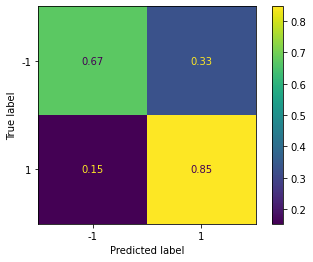

In [217]:
cm = confusion_matrix(train_labels_np, predictions, labels=clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

(1849,)


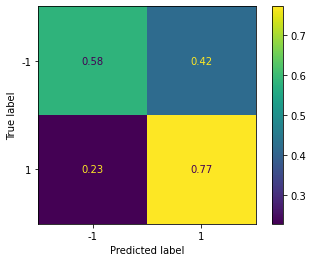

In [214]:
predictions = clf.predict(test_latents)
print(predictions.shape)
cm = confusion_matrix(test_labels_np, predictions, labels=clf.classes_, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [198]:
cm

array([[0.58176101, 0.41823899],
       [0.22793296, 0.77206704]])